# UNet Image Segmentation on Oxford-IIIT Pet Dataset
This notebook is a cell-wise structured version of your Python script.  
All logic remains identical — only organized into Jupyter Notebook format.


In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split

## Configuration

In [12]:
# ============================================
# CONFIGURATION
# ============================================
class Config:
    IMAGES_DIR = "images"
    MASKS_DIR = "annotations/trimaps"
    TRAINVAL_FILE = "annotations/trainval.txt"

    IMAGE_SIZE = 128
    BATCH_SIZE = 8
    LEARNING_RATE = 1e-4
    EPOCHS = 20
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    VAL_SPLIT = 0.2
    RANDOM_SEED = 42

config = Config()

## Dataset Class

In [13]:
# ============================================
# DATASET CLASS
# ============================================
class PetSegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        mask = Image.open(self.mask_paths[idx])
        mask = np.array(mask)
        mask = (mask <= 2).astype(np.uint8)
        mask = Image.fromarray(mask)

        if self.transform:
            image = self.transform(image)
            mask = transforms.Resize((config.IMAGE_SIZE, config.IMAGE_SIZE))(mask)
            mask = transforms.ToTensor()(mask)

        return image, mask

## Load Dataset Paths

In [14]:
# ============================================
# DATA LOADING AND PREPROCESSING
# ============================================
def load_dataset_paths(trainval_file, images_dir, masks_dir):
    image_paths = []
    mask_paths = []

    with open(trainval_file, 'r') as f:
        for line in f:
            filename = line.strip().split()[0]
            img_path = os.path.join(images_dir, f"{filename}.jpg")
            mask_path = os.path.join(masks_dir, f"{filename}.png")

            if os.path.exists(img_path) and os.path.exists(mask_path):
                image_paths.append(img_path)
                mask_paths.append(mask_path)

    print(f"Found {len(image_paths)} valid image-mask pairs")
    return image_paths, mask_paths

train_transform = transforms.Compose([
    transforms.Resize((config.IMAGE_SIZE, config.IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((config.IMAGE_SIZE, config.IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## UNet Architecture

In [15]:
# ============================================
# UNET ARCHITECTURE
# ============================================
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()

        self.enc1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.enc3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        self.enc4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = DoubleConv(1024, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(128, 64)

        self.out = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool1(enc1))
        enc3 = self.enc3(self.pool2(enc2))
        enc4 = self.enc4(self.pool3(enc3))
        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat([dec4, enc4], dim=1)
        dec4 = self.dec4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat([dec3, enc3], dim=1)
        dec3 = self.dec3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat([dec2, enc2], dim=1)
        dec2 = self.dec2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat([dec1, enc1], dim=1)
        dec1 = self.dec1(dec1)

        return torch.sigmoid(self.out(dec1))

## Training Functions

In [16]:
# ============================================
# TRAINING FUNCTIONS
# ============================================
def dice_coefficient(pred, target, smooth=1e-6):
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    total_dice = 0

    for images, masks in dataloader:
        images, masks = images.to(device), masks.to(device)

        outputs = model(images)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pred_masks = (outputs > 0.5).float()
        total_dice += dice_coefficient(pred_masks, masks).item()

    return total_loss / len(dataloader), total_dice / len(dataloader)

def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    total_dice = 0

    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)

            total_loss += loss.item()
            pred_masks = (outputs > 0.5).float()
            total_dice += dice_coefficient(pred_masks, masks).item()

    return total_loss / len(dataloader), total_dice / len(dataloader)

## Visualization

In [17]:
# ============================================
# VISUALIZATION
# ============================================
def visualize_predictions(model, dataloader, device, num_samples=3):
    model.eval()
    images, masks = next(iter(dataloader))
    images, masks = images.to(device), masks.to(device)

    with torch.no_grad():
        outputs = model(images)
        pred_masks = (outputs > 0.5).float()

    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(device)

    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))

    for i in range(num_samples):
        img = images[i] * std + mean
        img = img.cpu().permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)

        axes[i, 0].imshow(img)
        axes[i, 0].set_title('Original Image')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(masks[i, 0].cpu().numpy(), cmap='gray')
        axes[i, 1].set_title('Ground Truth Mask')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(pred_masks[i, 0].cpu().numpy(), cmap='gray')
        axes[i, 2].set_title('Predicted Mask')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

## Main Execution

UNet Image Segmentation Training
Found 3680 valid image-mask pairs
Epoch [1/20] | Train 0.2700 | Dice 0.0011 | Val 0.1739 | Dice 0.0000
Epoch [2/20] | Train 0.1323 | Dice 0.0001 | Val 0.0983 | Dice 0.0000
Epoch [3/20] | Train 0.0804 | Dice 0.0000 | Val 0.0656 | Dice 0.0001
Epoch [4/20] | Train 0.0550 | Dice 0.0000 | Val 0.0470 | Dice 0.0000
Epoch [5/20] | Train 0.0412 | Dice 0.0000 | Val 0.0366 | Dice 0.0000
Epoch [6/20] | Train 0.0337 | Dice 0.0000 | Val 0.0310 | Dice 0.0000
Epoch [7/20] | Train 0.0293 | Dice 0.0000 | Val 0.0277 | Dice 0.0000
Epoch [8/20] | Train 0.0267 | Dice 0.0000 | Val 0.0259 | Dice 0.0000
Epoch [9/20] | Train 0.0251 | Dice 0.0000 | Val 0.0247 | Dice 0.0000
Epoch [10/20] | Train 0.0242 | Dice 0.0000 | Val 0.0239 | Dice 0.0000
Epoch [11/20] | Train 0.0237 | Dice 0.0000 | Val 0.0237 | Dice 0.0000
Epoch [12/20] | Train 0.0234 | Dice 0.0000 | Val 0.0234 | Dice 0.0000
Epoch [13/20] | Train 0.0233 | Dice 0.0000 | Val 0.0233 | Dice 0.0000
Epoch [14/20] | Train 0.0232 | D

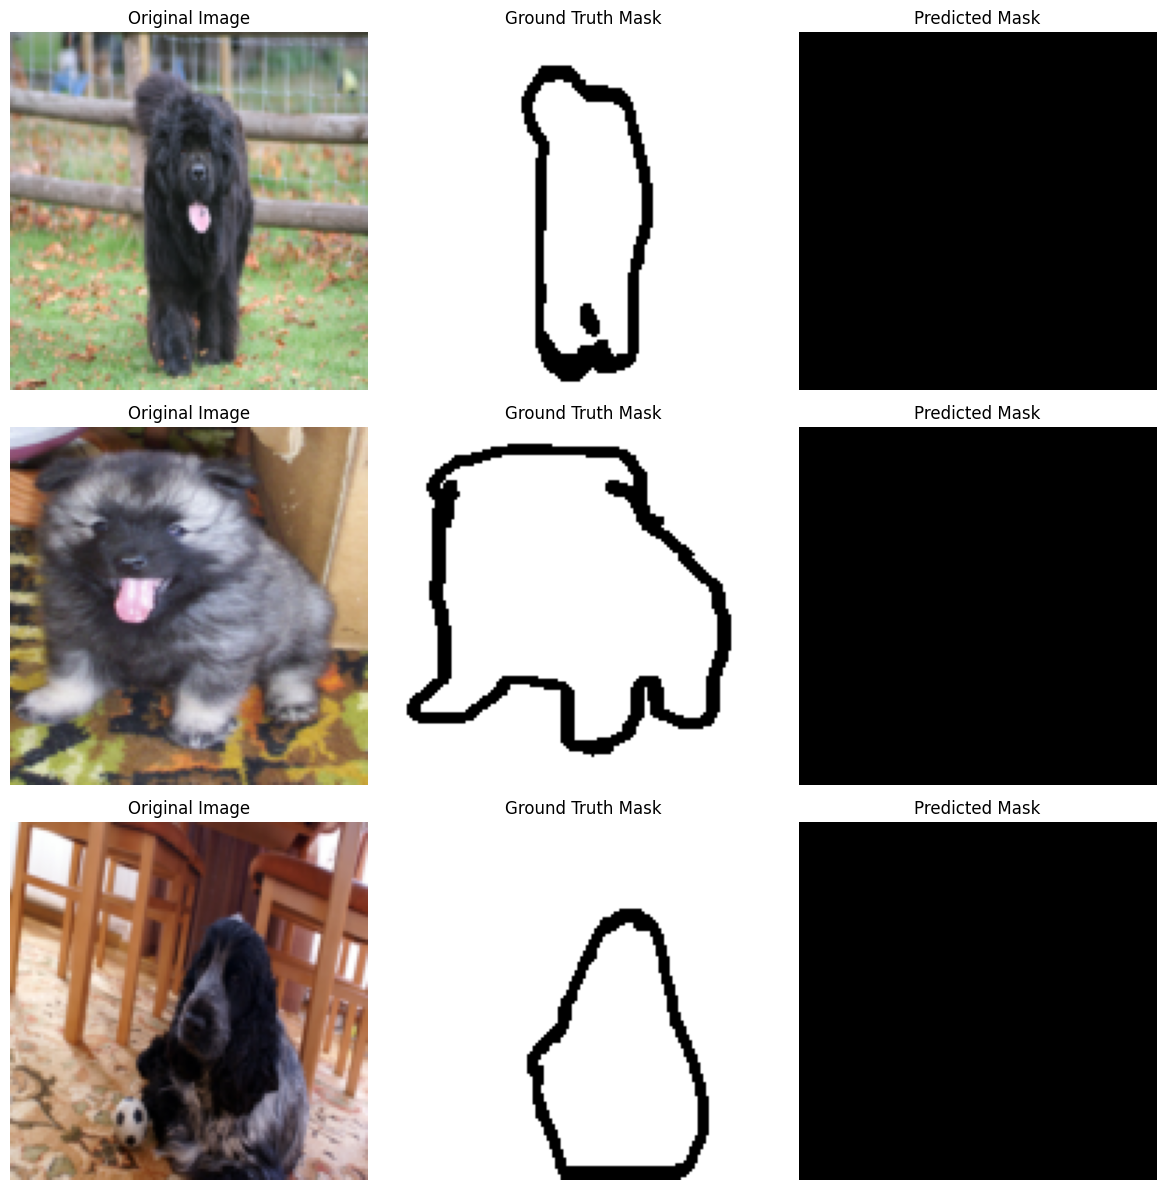

In [18]:
# ============================================
# MAIN EXECUTION
# ============================================
def main():
    print("="*50)
    print("UNet Image Segmentation Training")
    print("="*50)

    image_paths, mask_paths = load_dataset_paths(
        config.TRAINVAL_FILE, 
        config.IMAGES_DIR, 
        config.MASKS_DIR
    )

    train_imgs, val_imgs, train_masks, val_masks = train_test_split(
        image_paths, mask_paths, 
        test_size=config.VAL_SPLIT, 
        random_state=config.RANDOM_SEED
    )

    train_dataset = PetSegmentationDataset(train_imgs, train_masks, train_transform)
    val_dataset = PetSegmentationDataset(val_imgs, val_masks, val_transform)

    train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False)

    model = UNet(in_channels=3, out_channels=1).to(config.DEVICE)

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE)

    train_losses = []
    val_losses = []
    train_dices = []
    val_dices = []
    best_val_dice = 0

    for epoch in range(config.EPOCHS):
        train_loss, train_dice = train_epoch(model, train_loader, criterion, optimizer, config.DEVICE)
        val_loss, val_dice = validate(model, val_loader, criterion, config.DEVICE)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_dices.append(train_dice)
        val_dices.append(val_dice)

        print(f"Epoch [{epoch+1}/{config.EPOCHS}] | Train {train_loss:.4f} | Dice {train_dice:.4f} | Val {val_loss:.4f} | Dice {val_dice:.4f}")

        if val_dice > best_val_dice:
            best_val_dice = val_dice
            torch.save(model.state_dict(), "best_unet_model.pth")

    visualize_predictions(model, val_loader, config.DEVICE)

if __name__ == "__main__":
    main()